In [7]:
pip install librosa


   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   -------------- ------------------------- 92.2/260.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  256.0/260.1 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 260.1/260.1 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 24.8 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 12.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/166.7 kB ? eta -:--:--
   ---------------------------------------- 166.7/166.7 kB 5.0 MB/s eta 0:00:00


In [92]:
import requests
import tarfile
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import seaborn as sns
import pandas as pd

### Downloading + Extracting Speech Commands dataset

In [3]:
url = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
output_file = "speech_commands_v0.02.tar.gz"


In [4]:
print("Downloading dataset...")
response = requests.get(url, stream=True)
with open(output_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)
print(f"Dataset downloaded as {output_file}.")

Dataset downloaded as speech_commands_v0.02.tar.gz.


In [5]:
print("Extracting dataset...")
with tarfile.open(output_file, "r:gz") as tar:
    tar.extractall(path="speech_commands_dataset")
print("Dataset extracted to 'speech_commands_dataset' folder.")

Extracting dataset...
Dataset extracted to 'speech_commands_dataset' folder.


In [86]:
dataset_path = r"data\audio\Speech Commands"
# List all files and directories
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Directory: {dirpath}")
    print(f"Number of files: {len(filenames)}")
    print()


In [9]:
audio_data = []

for dirpath, dirnames, filenames in os.walk(dataset_path):
    for file_name in filenames:
        if file_name.endswith(".wav"):
            file_path = os.path.join(dirpath, file_name)
            # Load audio file
            y, sr = librosa.load(file_path, sr=None)  # sr=None keeps the original sampling rate
            duration = librosa.get_duration(y=y, sr=sr)
            label = os.path.basename(dirpath)  # Assume the folder name is the label
            audio_data.append({"file_path": file_path, "label": label, "duration": duration, "sampling_rate": sr})

# Convert to DataFrame
import pandas as pd
audio_df = pd.DataFrame(audio_data)
print(audio_df.head())

                                           file_path     label  duration  \
0  speech_commands_dataset\backward\0165e0e8_noha...  backward       1.0   
1  speech_commands_dataset\backward\017c4098_noha...  backward       1.0   
2  speech_commands_dataset\backward\017c4098_noha...  backward       1.0   
3  speech_commands_dataset\backward\017c4098_noha...  backward       1.0   
4  speech_commands_dataset\backward\017c4098_noha...  backward       1.0   

   sampling_rate  
0          16000  
1          16000  
2          16000  
3          16000  
4          16000  


## Exploratory Data Analysis

In [10]:
audio_df.shape

(105835, 4)

In [11]:
print(audio_df["label"].value_counts())

label
five                  4052
zero                  4052
yes                   4044
seven                 3998
no                    3941
nine                  3934
down                  3917
one                   3890
go                    3880
two                   3880
stop                  3872
six                   3860
on                    3845
left                  3801
eight                 3787
right                 3778
off                   3745
four                  3728
three                 3727
up                    3723
dog                   2128
wow                   2123
house                 2113
marvin                2100
bird                  2064
happy                 2054
cat                   2031
sheila                2022
bed                   2014
tree                  1759
backward              1664
visual                1592
follow                1579
learn                 1575
forward               1557
_background_noise_       6
Name: count, dtype: in

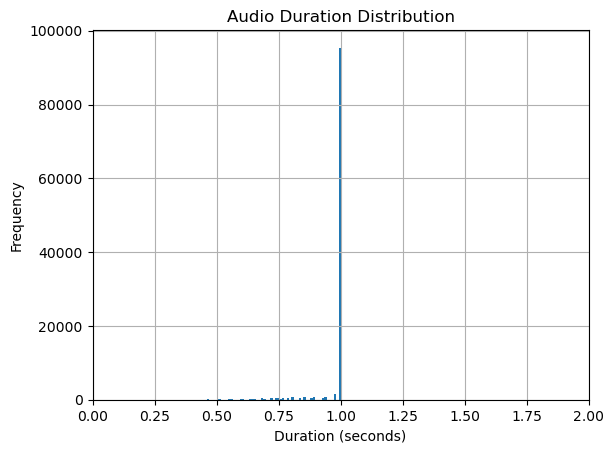

In [28]:
audio_df["duration"].hist(bins=10000)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.xlim(0,2)
plt.show()

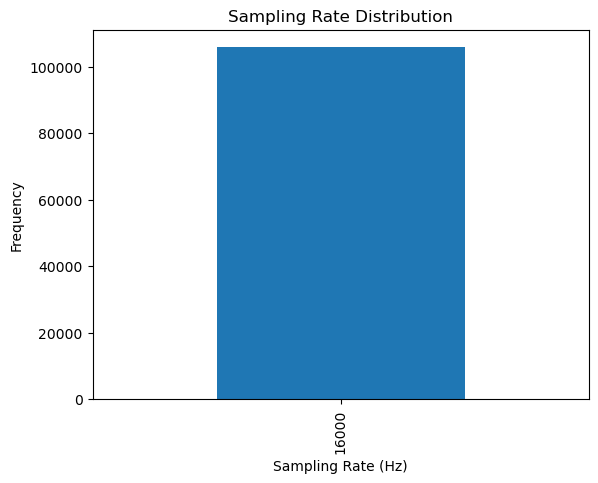

In [14]:
audio_df["sampling_rate"].value_counts().plot(kind="bar")
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Frequency")
plt.show()

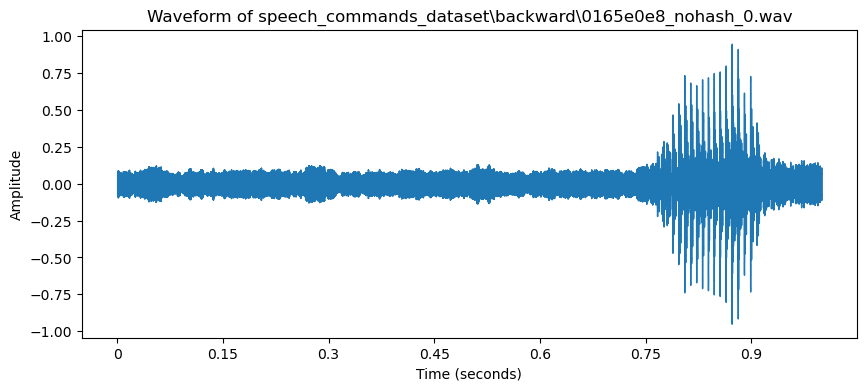

In [16]:
sample_file = audio_df["file_path"].iloc[0]
y, sr = librosa.load(sample_file, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {sample_file}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

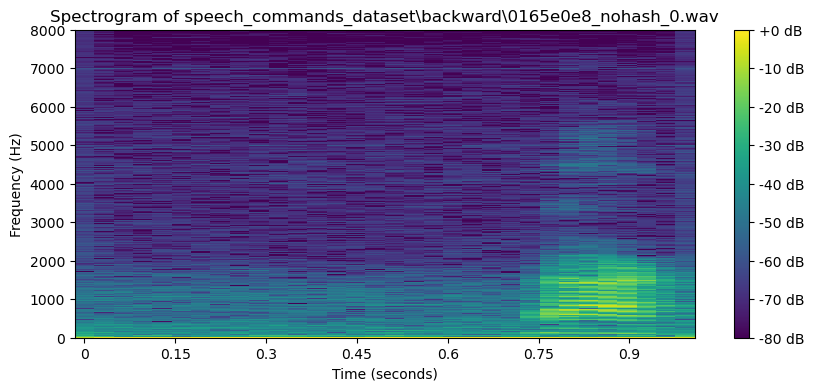

In [19]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="hz", cmap="viridis")
plt.title(f"Spectrogram of {sample_file}")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

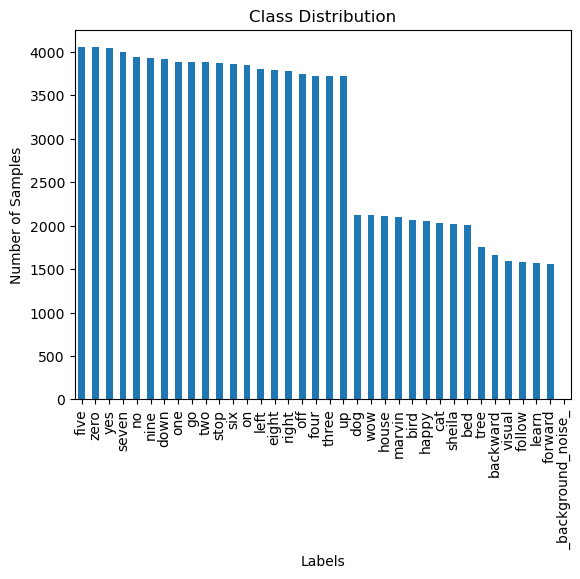

In [25]:
audio_df["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

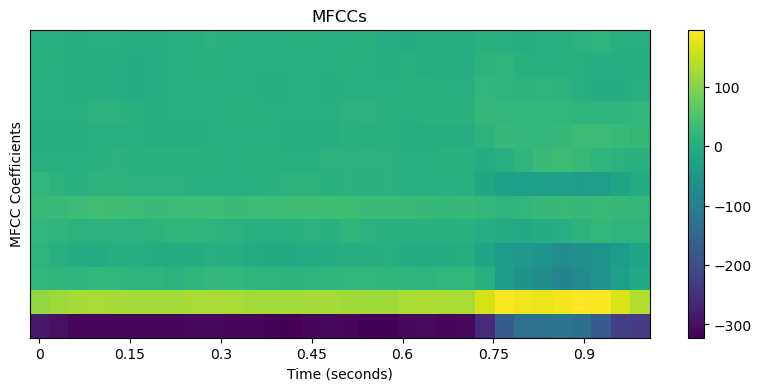

In [26]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time", cmap="viridis")
plt.title("MFCCs")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

In [27]:
audio_data[0]

{'file_path': 'speech_commands_dataset\\backward\\0165e0e8_nohash_0.wav',
 'label': 'backward',
 'duration': 1.0,
 'sampling_rate': 16000}

## Extracting pitch

In [82]:
## attempting with librosa normalization
sample_file = audio_df["file_path"].iloc[300]
y, sr = librosa.load(sample_file, sr=None)
f0 = librosa.yin(y, fmin=20, fmax=1000)
print(f0)

[245.00348838 191.28965644 192.18257749 190.86473432 184.43080751
 190.45774759 188.12538699 181.44820139 180.37329635 179.86953433
 182.70198446 185.48129162 182.97768942 140.07398503 449.86719626
 526.66810782 154.82050295 195.62748502 197.8173558  221.51372382
 789.78071127 802.06786579 138.2234035  139.20935714 139.54672235
 139.02778647 139.02855353  32.20786866 114.92419989 460.60297123
 463.16787777 112.67307042]


In [78]:
np.mean(f0)

244.7517231570614

In [79]:
## Functions to return pitch and average pitch of sample

def return_pitch(sample_num):
    sample_file = audio_df['file_path'].iloc[sample_num]
    y, sr = librosa.load(sample_file, sr=None)
    f0 = librosa.yin(y, fmin=20, fmax=1000)
    return f0

def average_pitch(sample_num):
    sample_file = audio_df['file_path'].iloc[sample_num]
    y, sr = librosa.load(sample_file, sr=None)
    f0 = librosa.yin(y, fmin=20, fmax=1000)
    return np.mean(f0)

In [74]:
return_pitch(550)

array([ 97.38373668,  23.10634067,  34.39856124,  69.99808803,
        68.26335401,  23.02284241,  34.26603625,  34.21417606,
        67.9990628 ,  68.93721711,  69.53416359,  66.70092468,
        67.3262094 ,  68.19646675,  68.3437715 ,  73.02773447,
       279.23722475, 266.07529456, 254.81209289, 265.03164909,
       293.93162804, 289.91318062, 285.55521473, 280.64307391,
       268.62671745,  69.98481258,  23.22531874,  34.98956277,
       352.51244632, 233.06291207, 226.89575192])

In [80]:
average_pitch(550)

140.6198569701944

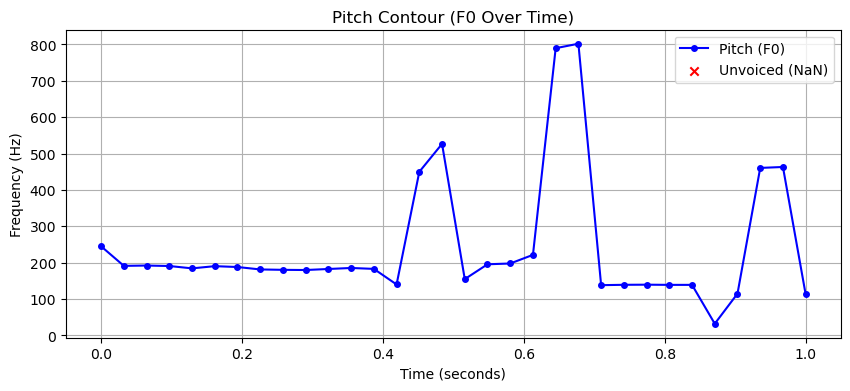

In [83]:
# Compute time axis for f0
times = np.linspace(0, len(y) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

In [84]:
# trying different audio sample
sample_file = audio_df["file_path"].iloc[60000]
y, sr = librosa.load(sample_file, sr=None)
f0 = librosa.yin(y, fmin=20, fmax=1000)
print(f0)

[884.34793842 187.74935254 158.91557523 140.39669667  89.6304336
 521.60852069 220.35502123 168.90024171 165.95370901 163.64924871
 161.19664029 158.11652305 155.51492735 151.69224034 147.02335765
 147.49636367 151.24892451 166.40121341  23.04076636  37.00191018
  47.48611926  23.28148197  22.21608906  34.28213902 168.99884455
  37.7730294  222.97028319 112.91266794 107.60196676  81.883852
  23.43760905  23.36055805]


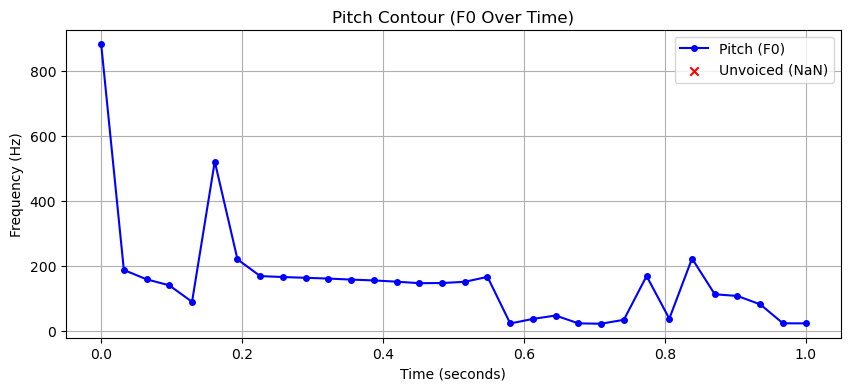

In [85]:
# Compute time axis for f0
times = np.linspace(0, len(y) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

## Extracting pitch statistics across dataset

In [90]:
dataset_path = r"data\audio\Speech Commands"
# List to store pitch data
pitch_data = []

# Iterate through each word directory
for word in os.listdir(dataset_path):
    word_path = os.path.join(dataset_path, word)
    
    # Check if it's a directory (i.e., a class)
    if os.path.isdir(word_path):
        # Iterate through audio files in the word directory
        for file in os.listdir(word_path):
            if file.endswith(".wav"):
                file_path = os.path.join(word_path, file)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute pitch (F0) using YIN
                # Can change fmin to lower value and fmax to higher value
                f0 = librosa.yin(y, fmin=50, fmax=500)

                # Remove NaNs (unvoiced regions)
                f0 = f0[~np.isnan(f0)]
                
                if len(f0) > 0:  # Only consider files where pitch was detected
                    pitch_data.append({
                        "word": word,
                        "file": file,
                        "mean_f0": np.mean(f0),
                        "median_f0": np.median(f0),
                        "std_f0": np.std(f0),
                        "min_f0": np.min(f0),
                        "max_f0": np.max(f0)
                    })

In [94]:
# Convert to Pandas DataFrame
pitch_df = pd.DataFrame(pitch_data)

# Save to CSV for further analysis
pitch_df.to_csv("pitch_statistics.csv", index=False)

# Display first few rows
print(pitch_df.head())

       word                   file     mean_f0   median_f0      std_f0  \
0  backward  0165e0e8_nohash_0.wav  137.148488   88.974269   81.460148   
1  backward  017c4098_nohash_0.wav  144.911770  119.826448  104.334735   
2  backward  017c4098_nohash_1.wav  141.948199  111.207695  109.615272   
3  backward  017c4098_nohash_2.wav  169.122308  118.557588  118.709700   
4  backward  017c4098_nohash_3.wav  154.573501  146.064696  104.684605   

      min_f0      max_f0  
0  61.079010  409.261365  
1  53.170360  447.479949  
2  50.763738  478.063223  
3  50.990918  501.136364  
4  53.892310  437.991517  


In [ ]:
## Visualizing the pitch statistics

C:\Users\shane\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


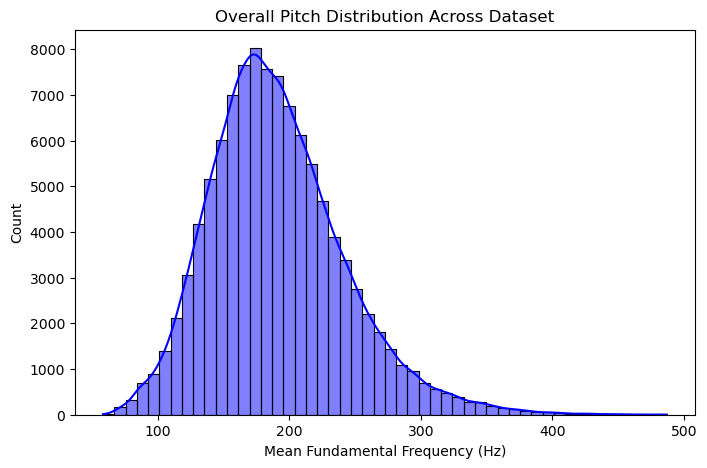

In [95]:
plt.figure(figsize=(8, 5))
sns.histplot(pitch_df["mean_f0"], bins=50, kde=True, color="blue")
plt.xlabel("Mean Fundamental Frequency (Hz)")
plt.ylabel("Count")
plt.title("Overall Pitch Distribution Across Dataset")
plt.show()

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

https://www.dpamicrophones.com/mic-university/background-knowledge/facts-about-speech-intelligibility/#:~:text=In%20general%2C%20the%20fundamental%20frequency,f0%20is%20around%20300%20Hz.

Our dataset follows this general distrubtion of pitch 

In [96]:
## pitch distribution per word

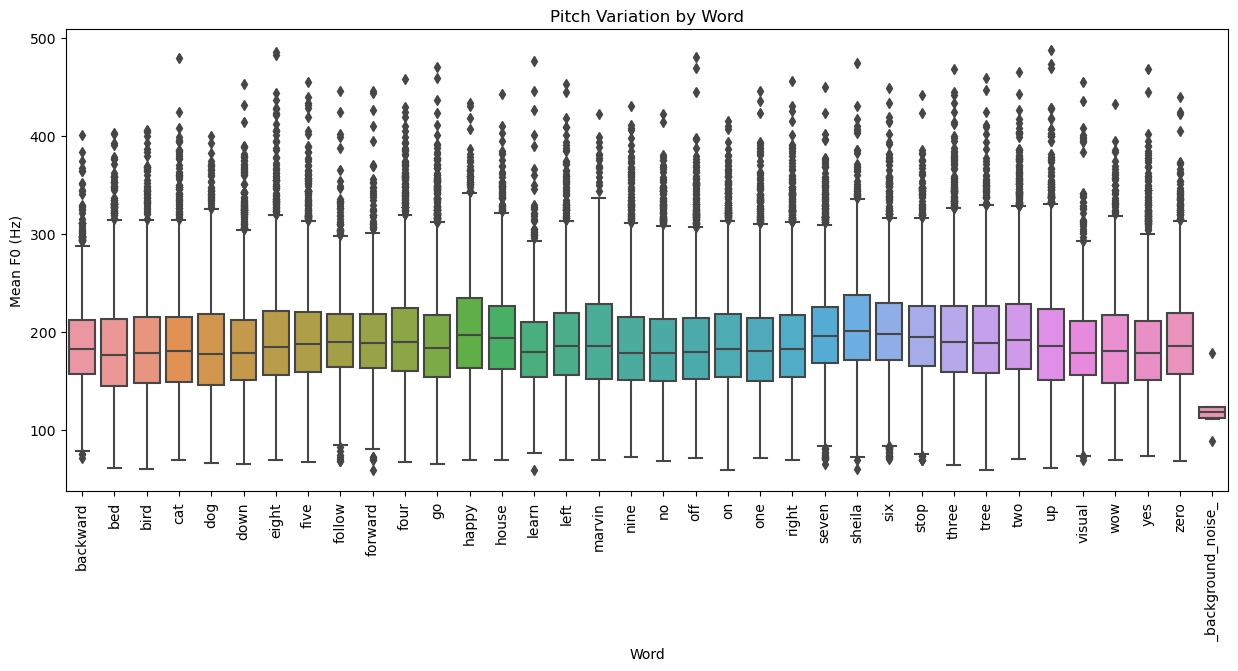

In [97]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=pitch_df, x="word", y="mean_f0")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Variation by Word")
plt.show()

In [98]:
## Density of Pitch per word

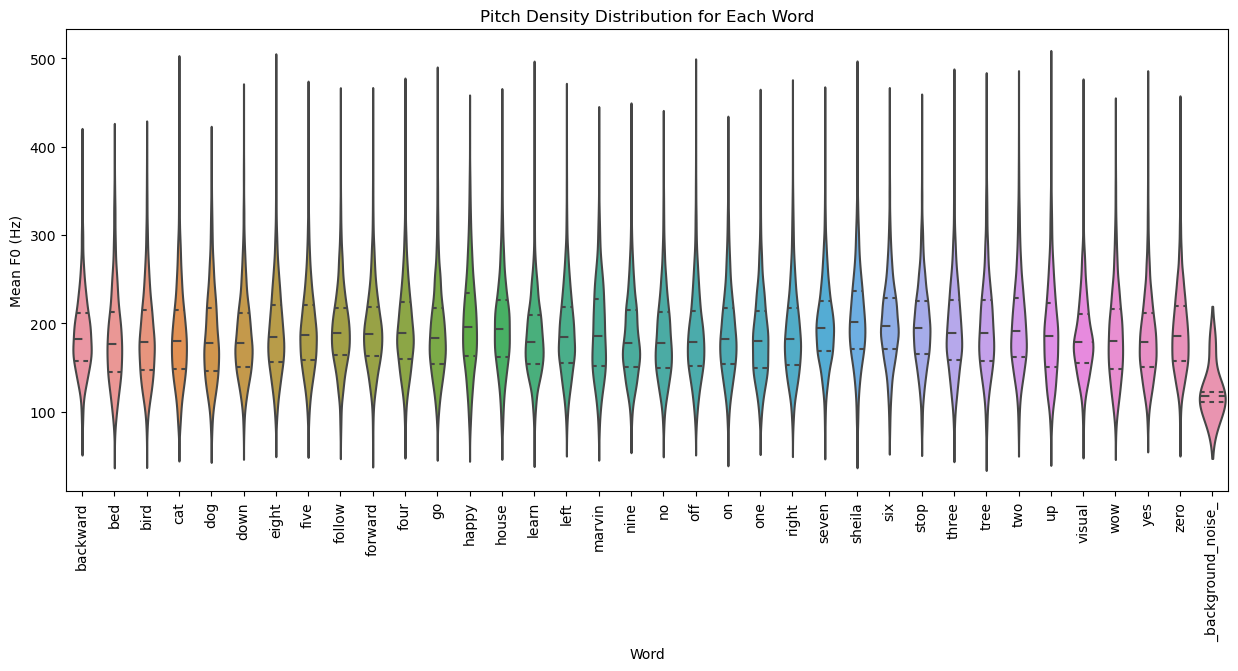

In [99]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=pitch_df, x="word", y="mean_f0", inner="quartile")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Density Distribution for Each Word")
plt.show()